# Guardrails Lab

Welcome! This mini-lab helps you create guardrail agents to build a safe AI framework OpenAI's agents SDK.

Objectives:
- Apply guardrails to control LLM inputs/outputs  
- Detect and mitigate PII or sensitive content  
- Enforce safer response patterns and constraints  
- Integrate guardrails into agent-based workflows  

## Install Dependencies
Set up the notebook environment by upgrading the SDK and UI packages required later.

In [ ]:
!pip install -qU openai-agents gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/150.7 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.4/463.4 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.9 MB/s eta 0:00:00


## Load Libraries and Prompt Templates
Import the helper modules, Colab integrations, and prompt strings used throughout the workflow.


In [ ]:
import asyncio
import base64
import os
from io import BytesIO
from typing import Any, Dict
import json
import requests
from IPython.display import display, Image

import gradio as gr
import PIL
from google.colab import userdata
from openai import OpenAI
from openai.types.responses import ResponseTextDeltaEvent
from agents import (
    Agent,
    GuardrailFunctionOutput,
    OutputGuardrailTripwireTriggered,
    Runner,
    input_guardrail,
    output_guardrail
)
from pydantic import BaseModel

MODEL = "gpt-5-mini"

DEFAULT_PROMPT = "Describe the main subjects and setting of this image."

TA_VISION_INSTRUCTIONS = """
You are TA Owl, a meticulous teaching assistant.
Your job is to DESCRIBE the image in full detail so another agent can teach from it.

For each image:
1) Start with a short factual title (e.g., "Bar chart of quarterly revenue").
2) Give an exhaustive, literal description: all text, labels, axes, legends, colors, arrows,
   cardinalities, UI elements, code structure, and notable values or patterns.
3) Mention only obvious issues (e.g., missing labels, low contrast) under "Improvements Noticed".

Do NOT summarize, interpret, or teach. Only describe what is visible.
""".strip()

PROF_INSTRUCTIONS = """
You are Professor Owl, a warm Business Analytics instructor.
You receive dense visual descriptions from TA Owl and turn them into student-friendly summaries.

For each TA description:
1) Give a clear, friendly title.
2) Summarize only the key components and relationships that matter conceptually.
3) Explain why it matters for analysis, modeling, or business decisions.
4) Add 1–2 short tips on what a student should focus on.

Do NOT invent details not in the TA’s description.
Unless crucially important, do NOT repeat TA's detailed descriptions and only add helpful concepts to them.
Avoid layout minutiae; focus on meaning, intuition, and clarity.
Do NOT offer lengthy and detailed explanations and keep it concise.
End with a signature "Prof. O"
""".strip()

GUARDRAIL_INSTRUCTIONS = """
You are Guardrail Owl.
Classify the user-uploaded image for two criteria:
1) Is it technical and related to data/analytics/BI/ML/stats/visualization/code/SQL?
2) Is it free of insults, hate, sexual or otherwise inappropriate content?

Return JSON with keys: is_technical (bool), is_civil (bool), brief_reason (string).
Only base your judgment on the provided image and short prompt.
""".strip()


## Configure Credentials
Pull the OpenAI API key from Colab `userdata` so all later calls reuse the same secret safely.

In [ ]:
os.environ["OPENAI_API_KEY"] = userdata.get("OpenAI_API_Key")

## Runtime Setup Overview
Introduce the core client and helper utilities leveraged by the agents.

### Build Vision Helper Utilities
Define image serialization helpers and validate them by constructing a sample payload.


[{'role': 'user',
  'content': [{'type': 'input_text',
    'text': 'Describe the main subjects and setting of this image.'},
   {'type': 'input_image',
    'image_url': ''}]}]
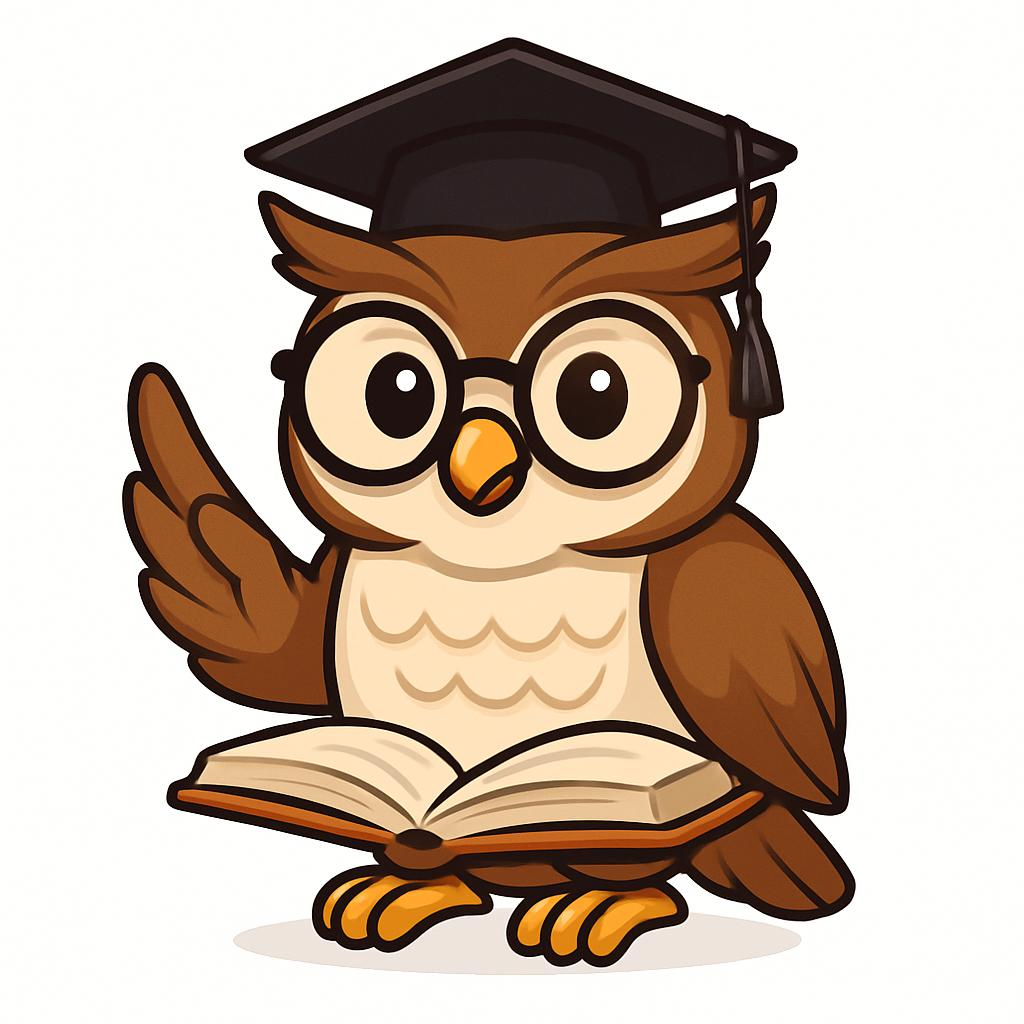

In [ ]:
def _image_to_base64(image):
    if image is None:
        raise ValueError("An image is required.")
    if image.mode != "RGB":
        image = image.convert("RGB")
    buffer = BytesIO()
    image.save(buffer, format="JPEG")
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

def build_image_input_data(image: PIL.Image.Image, prompt_text: str) -> Dict[str, Any]:
    return [
        {
            "role": "user",
            "content": [
                {
                    "type": "input_text",
                    "text": (prompt_text or "").strip(),
                },
                {
                    "type": "input_image",
                    "image_url": f"data:image/jpeg;base64,{_image_to_base64(image)}",
                },
            ],
        }
    ]

# Test the helper functions
URL = "https://raw.githubusercontent.com/soltaniehha/Business-Analytics-Toolbox/master/docs/images/ERD-Example.png"
#URL = "https://raw.githubusercontent.com/soltaniehha/Business-Analytics-Toolbox/master/docs/images/giraffe.jpg"
URL = "https://raw.githubusercontent.com/soltaniehha/Business-Analytics-Toolbox/master/docs/images/Prof-Owl-1.png"
response = requests.get(URL)
image = PIL.Image.open(BytesIO(response.content))

input_data = build_image_input_data(image, DEFAULT_PROMPT)
input_data

### Preview the Reference Image
Render the example directly in the notebook to pair the streamed text output with the original visual.


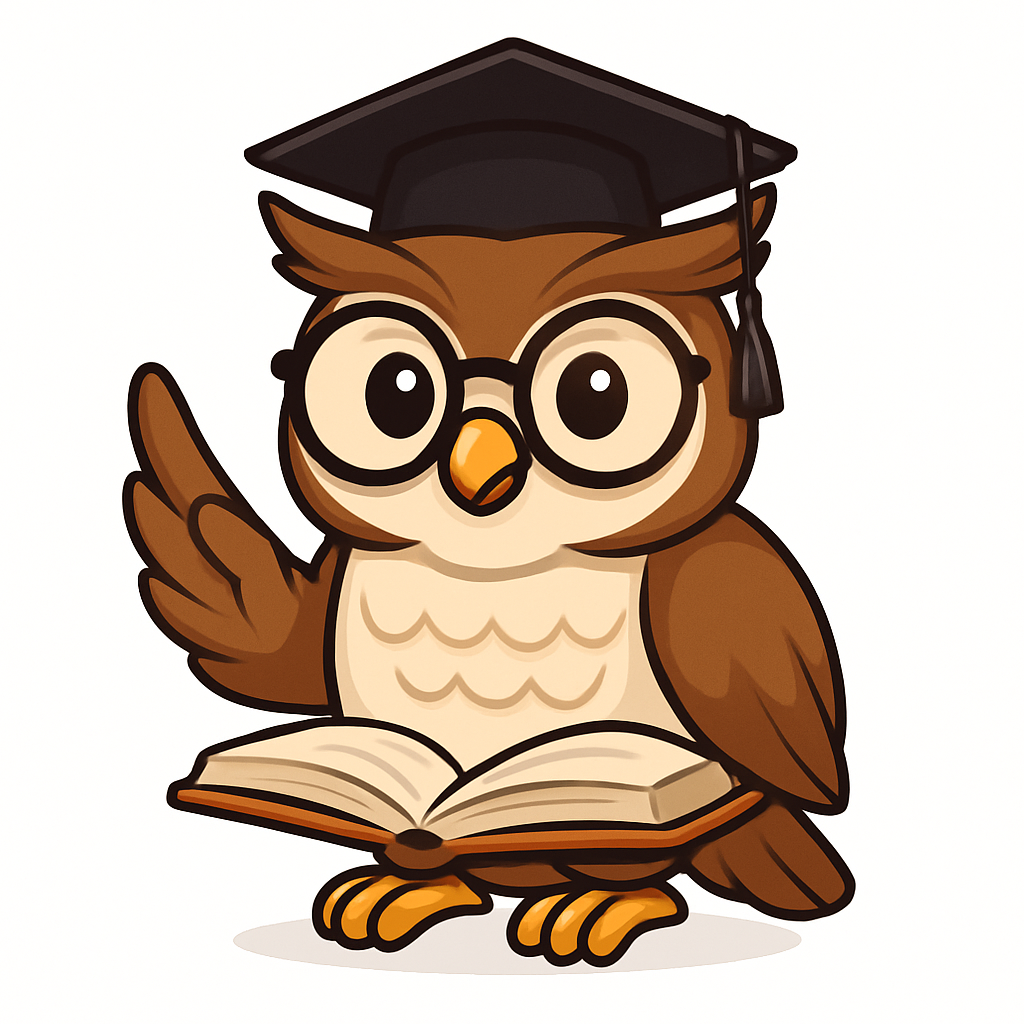

In [ ]:
display(image)

## Configure TA Owl Agent
Instantiate the Agents SDK worker that produces exhaustive image descriptions for understanding & debugging purposes.

In [ ]:
ta_vision_agent = Agent(
    name="ta_owl",
    model=MODEL,
    instructions=TA_VISION_INSTRUCTIONS
)

In [ ]:
ta_vision_agent

Agent(name='ta_owl', handoff_description=None, tools=[], mcp_servers=[], mcp_config={}, instructions='You are TA Owl, a meticulous teaching assistant.\nYour job is to DESCRIBE the image in full detail so another agent can teach from it.\n\nFor each image:\n1) Start with a short factual title (e.g., "Bar chart of quarterly revenue").\n2) Give an exhaustive, literal description: all text, labels, axes, legends, colors, arrows,\n   cardinalities, UI elements, code structure, and notable values or patterns.\n3) Mention only obvious issues (e.g., missing labels, low contrast) under "Improvements Noticed".\n\nDo NOT summarize, interpret, or teach. Only describe what is visible.', prompt=None, handoffs=[], model='gpt-5-mini', model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=None, truncation=None, max_tokens=None, reasoning=None, verbosity=None, metadata=None, store=None, include_usage=None, response

## Configure Professor Owl Agent
Set up the summarization agent and stream the higher-level explanation that pairs with TA's findings.


In [ ]:
prof_agent = Agent(
    name="prof_owl",
    model=MODEL,
    instructions=PROF_INSTRUCTIONS,
)

## Add Guardrail Agent
A lightweight guardrail agent checks uploaded images before analysis. It blocks non-technical or inappropriate images and returns a brief message.


In [ ]:
class MessageOutput(BaseModel):
    response: str

class ImageGuardrailOutput(BaseModel):
    is_technical: bool
    is_civil: bool
    brief_reason: str

# Configure Guardrail Agent and decorator
guard_agent = Agent(
    name="guard_owl",
    model=MODEL,
    instructions=GUARDRAIL_INSTRUCTIONS,
    output_type=ImageGuardrailOutput,
)

@output_guardrail
async def guardrail_on_ta_output(ctx, agent, ta_output):
    # ta_output is the TA's final_output (MessageOutput or something else)
    if isinstance(ta_output, MessageOutput):
        guard_input = ta_output.response
    else:
        guard_input = str(ta_output)

    # Now pass a plain string to guard_agent
    result = await Runner.run(guard_agent, guard_input, context=ctx.context)

    guard = result.final_output  # this is ImageGuardrailOutput

    tripwire = not (guard.is_technical and guard.is_civil)

    return GuardrailFunctionOutput(
        tripwire_triggered=tripwire,
        output_info={
            "guardrail": guard,
            "message": guard.brief_reason,
        },
    )

## Reconfigure TA Agent
Here we will add our guardrail:

In [ ]:
ta_vision_agent = Agent(
    name="ta_owl",
    model=MODEL,
    instructions=TA_VISION_INSTRUCTIONS,
    output_guardrails=[guardrail_on_ta_output],
    output_type=MessageOutput,
)

ta_vision_agent

Agent(name='ta_owl', handoff_description=None, tools=[], mcp_servers=[], mcp_config={}, instructions='You are TA Owl, a meticulous teaching assistant.\nYour job is to DESCRIBE the image in full detail so another agent can teach from it.\n\nFor each image:\n1) Start with a short factual title (e.g., "Bar chart of quarterly revenue").\n2) Give an exhaustive, literal description: all text, labels, axes, legends, colors, arrows,\n   cardinalities, UI elements, code structure, and notable values or patterns.\n3) Mention only obvious issues (e.g., missing labels, low contrast) under "Improvements Noticed".\n\nDo NOT summarize, interpret, or teach. Only describe what is visible.', prompt=None, handoffs=[], model='gpt-5-mini', model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=None, truncation=None, max_tokens=None, reasoning=None, verbosity=None, metadata=None, store=None, include_usage=None, response

## Test

In [ ]:
try:
    # Submit the sample image and stream the output
    ta_result = Runner.run_streamed(ta_vision_agent, input_data)

    async for event in ta_result.stream_events():
        if event.type == "raw_response_event" and isinstance(event.data, ResponseTextDeltaEvent):
            print(event.data.delta, end="", flush=True)

except OutputGuardrailTripwireTriggered as trip:
    print("\n\n Guardrail rejects the image. Reason: ", trip.guardrail_result.output.output_info.get("message"))

{"response":"Title: Cartoon owl wearing a graduation cap while perched on an open book\n\nDescription:\n- Main subject: a stylized, cartoon owl centered in the image.\n- Overall pose: the owl is shown facing forward. Its left wing (viewer’s right) is lowered alongside its body; its right wing (viewer’s left) is raised with the wing tip pointing upward as if gesturing.\n- Head and facial features:\n  - The owl has a rounded head with small feather tufts at the top outer edges.\n  - Large, circular eyeglasses with thick black frames sit over the eyes; the frames have a bridge across the beak area.\n  - Eyes: very large round eyes with black pupils and small white highlights (reflections) in each pupil.\n  - Beak: short, triangular, orange-yellow beak centered below the eyes with a dark outline.\n  - Facial coloring: the face area around the eyes is a lighter cream/beige color, with darker brown outlining and shading.\n- Headwear: a black graduation mortarboard sits on the owl’s head. The

## Define the Streaming Orchestrator
Implement an async handler that sequences TA Owl and Professor Owl responses for each upload.

In [ ]:
# --- Gradio handler: run TA then Professor ---
async def analyze_image_stream(image, prompt):
    if image is None:
        yield "Please upload an image.", ""
        return

    prompt = prompt or DEFAULT_PROMPT
    input_data = build_image_input_data(image, prompt)

    # --- TA Owl: run full result without streaming until the guardrail is checked ---
    ta_text_accum = ""
    try:
        ta_result = await Runner.run(ta_vision_agent, input_data)

        # final_output can be either MessageOutput or a plain string
        fo = ta_result.final_output.response
        if isinstance(fo, MessageOutput):
            ta_full = fo.response
        else:
            # fall back to string representation if it's not the expected type
            ta_full = str(fo)

    except OutputGuardrailTripwireTriggered as trip:
        # Friendly message when the guardrail blocks processing
        msg = "Guardrail rejects the image. Reason: " + trip.guardrail_result.output.output_info.get("message")
        yield msg, ""
        return

    # --- Professor Owl: stream student-friendly explanation ---
    prof_prompt = (
        f"Initial prompt: {prompt}\n\n"
        f"TA findings from the image:\n{ta_full}"
    )
    prof_stream = Runner.run_streamed(prof_agent, prof_prompt)
    prof_text_accum = ""

    async for event in prof_stream.stream_events():
        if event.type == "raw_response_event" and isinstance(event.data, ResponseTextDeltaEvent):
            prof_text_accum += event.data.delta
            yield ta_full, prof_text_accum

### Launch the Gradio Interface
Assemble the Blocks layout so users can upload an image, tweak the prompt, and watch both agents stream in real time.


In [ ]:
with gr.Blocks() as demo:
    gr.Markdown("# 🦉 Professor Owl – Safe Vision Teaching Assistant")

    with gr.Row():
        with gr.Column():
            image_in = gr.Image(type="pil", label="Upload an image")
            prompt_in = gr.Textbox(
                label="Prompt (optional)",
                value=DEFAULT_PROMPT,
                lines=2
            )
            run_btn = gr.Button("Analyze image")

        with gr.Column():
            ta_out = gr.Textbox(
                label="TA Owl (Detailed description)",
                lines=12
            )
            prof_out = gr.Textbox(
                label="Professor Owl (Student-friendly summary)",
                lines=8
            )

    # Use the streaming function
    run_btn.click(
        fn=analyze_image_stream,
        inputs=[image_in, prompt_in],
        outputs=[ta_out, prof_out]
    )

demo.queue()  # recommended for streaming
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3fcf1930a8cac70a6c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
